In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.keras.backend.clear_session()

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense1')(inputs)
x = layers.Dense(64, activation='relu', name='dense2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                50240     
_________________________________________________________________
dense2 (Dense)               (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32')/255
x_test = x_test.reshape(10000, 784).astype('float32')/255
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [7]:
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

history = model.fit(x_train, y_train,
                   batch_size=64,
                   epochs=3,
                   validation_data=(x_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 2s 48us/sample - loss: 0.3507 - sparse_categorical_accuracy: 0.8997 - val_loss: 0.2536 - val_sparse_categorical_accuracy: 0.9199
Epoch 2/3
50000/50000 [==============================] - 2s 32us/sample - loss: 0.1689 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.1591 - val_sparse_categorical_accuracy: 0.9527
Epoch 3/3
50000/50000 [==============================] - 2s 32us/sample - loss: 0.1215 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.1202 - val_sparse_categorical_accuracy: 0.9657


In [8]:
results = model.evaluate(x_test, y_test, batch_size=128)


10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [11]:
model.predict(x_test[:3])

array([[6.02806196e-08, 2.33971761e-07, 7.75393564e-04, 8.79579596e-03,
        7.62602603e-09, 1.14480004e-04, 6.83486184e-11, 9.90297973e-01,
        4.57751003e-06, 1.14248942e-05],
       [7.62683783e-09, 5.56280538e-05, 9.99922395e-01, 2.14790507e-05,
        5.00752174e-12, 7.41162793e-08, 2.55937721e-07, 5.78842909e-13,
        2.90350272e-07, 3.83956674e-13],
       [9.78911430e-06, 9.90855455e-01, 5.33582363e-03, 4.41931974e-04,
        1.56884606e-04, 2.12557163e-04, 7.14282447e-04, 1.34079147e-03,
        8.98847647e-04, 3.35821642e-05]], dtype=float32)

In [14]:
import numpy as np
score = model.predict(x_test[:3])
predict=np.argmax(score,axis=1)
print(predict)

[7 2 1]


In [15]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [16]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name='digits')
    x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
    x = layers.Dense(64, activation='relu', name='dense_2')(x)
    outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def basic_loss_function(y_true, y_pred):
    return tf.math.reduce_mean(y_true, y_pred)

model.compile(optimizer=keras.optimizers.Adam(),
             loss=basic_loss_function)
model.fit(x_train, y_train, batch_size=64, epochs=3)

In [18]:
class WeightedBinaryCrossEntropy(keras.losses.Loss):
    def __init__(self, pos_weight, weight, from_logits=False,
                 reduction=keras.losses.Reduction.AUTO,
                 name='weighted_binary_crossentropy'):
        super(WeightedBinaryCrossEntropy, self).__init__(reduction=reduction,
                                                         name=name)
        self.pos_weight = pos_weight
        self.weight = weight
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if not self.from_logits:
            x_1 = y_true * self.pos_weight * -tf.math.log(y_pred + 1e-6)
            x_2 = (1 - y_true) * -tf.math.log(1 - y_pred + 1e-6)
            return tf.add(x_1, x_2) * self.weight 
        return tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, self.pos_weight) * self.weight

In [19]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name='categorical_true_positives', **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)

In [20]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.
    
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy')

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 2s 43us/sample - loss: 2.50871


In [21]:
class MetricLoggingLayer(layers.Layer):

  def call(self, inputs):
    # The `aggregation` argument defines
    # how to aggregate the per-batch values
    # over each epoch:
    # in this case we simply average them.
    self.add_metric(keras.backend.std(inputs),
                    name='std_of_activation',
                    aggregation='mean')
    return inputs  # Pass-through layer.

In [22]:
model.add_metric(keras.backend.std(x1),name='std',aggregation='mean')

NameError: name 'x1' is not defined

In [25]:
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 1s 34us/sample - loss: 2.3013 - val_loss: 2.3015


In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)
model.fit(train_dataset, epochs=3)

Epoch 1/3
782/782 [==============================] - 4s 5ms/step - loss: 2.3013
Epoch 2/3
782/782 [==============================] - 2s 2ms/step - loss: 2.3013
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 2.3013


In [27]:
model.evaluate(test_dataset)

157/157 [==============================] - 0s 2ms/step - loss: 2.3012


2.301150256661093

In [30]:
model.fit(train_dataset.take(10), epochs=3)

Epoch 1/3
10/10 [==============================] - 0s 15ms/step - loss: 2.3021
Epoch 2/3
10/10 [==============================] - 0s 13ms/step - loss: 2.3027
Epoch 3/3
10/10 [==============================] - 0s 13ms/step - loss: 2.3019


In [32]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)
model.fit(train_dataset.take(500), epochs=3, validation_data=val_dataset)

Epoch 1/3
500/500 [==============================] - 2s 4ms/step - loss: 2.3012 - val_loss: 0.0000e+00
Epoch 2/3
500/500 [==============================] - 1s 3ms/step - loss: 2.3011 - val_loss: 2.3026
Epoch 3/3
500/500 [==============================] - 1s 3ms/step - loss: 2.3010 - val_loss: 2.3027


In [33]:
model.fit(train_dataset, epochs=3,
          # Only run validation using the first 10 batches of the dataset
          # using the `validation_steps` argument
          validation_data=val_dataset, validation_steps=10)

Epoch 1/3
782/782 [==============================] - 3s 4ms/step - loss: 2.3012 - val_loss: 0.0000e+00
Epoch 2/3
782/782 [==============================] - 2s 2ms/step - loss: 2.3012 - val_loss: 2.3028
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 2.3012 - val_loss: 2.3027


In [37]:
import numpy as np

class_weight = {0: 1., 1: 1., 2: 1., 3: 1., 4: 1.,
                # Set weight "2" for class "5",
                # making this class 2x more important
                5: 2.,
                6: 1., 7: 1., 8: 1., 9: 1.}
print('Fit with class weight')
# model.fit(x_train, y_train,
#           class_weight=class_weight,
#           batch_size=64,
#           epochs=4)

# Here's the same example using `sample_weight` instead:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.
print('\nFit with sample weight')

model.fit(x_train, y_train,
          class_weight = 'auto',
          sample_weight=sample_weight,
          batch_size=64,
          epochs=4)

Fit with class weight

Fit with sample weight
Train on 50000 samples
Epoch 1/4
50000/50000 [==============================] - 2s 38us/sample - loss: 2.4998
Epoch 2/4
50000/50000 [==============================] - 2s 34us/sample - loss: 2.4875
Epoch 3/4
50000/50000 [==============================] - 2s 34us/sample - loss: 2.4872
Epoch 4/4
50000/50000 [==============================] - 2s 33us/sample - loss: 2.4872


In [38]:
from tensorflow import keras
from tensorflow.keras import layers

In [41]:
image_input = keras.Input(shape=(32,32,3),name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')
x1 = layers.Conv2D(3,3,)(image_input)
x1 = layers.GlobalMaxPool2D()(x1)

x2 = layers.Conv1D(3,3)(timeseries_input)
x2 = layers.GlobalMaxPool1D()(x2)

x = layers.concatenate([x1,x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, activation='softmax', name='class_output')(x)

model = keras.Model(inputs=[image_input, timeseries_input],
                   outputs=[score_output, class_output])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
ts_input (InputLayer)           [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 30, 30, 3)    84          img_input[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 3)      93          ts_input[0][0]                   
____________________________________________________________________________________________

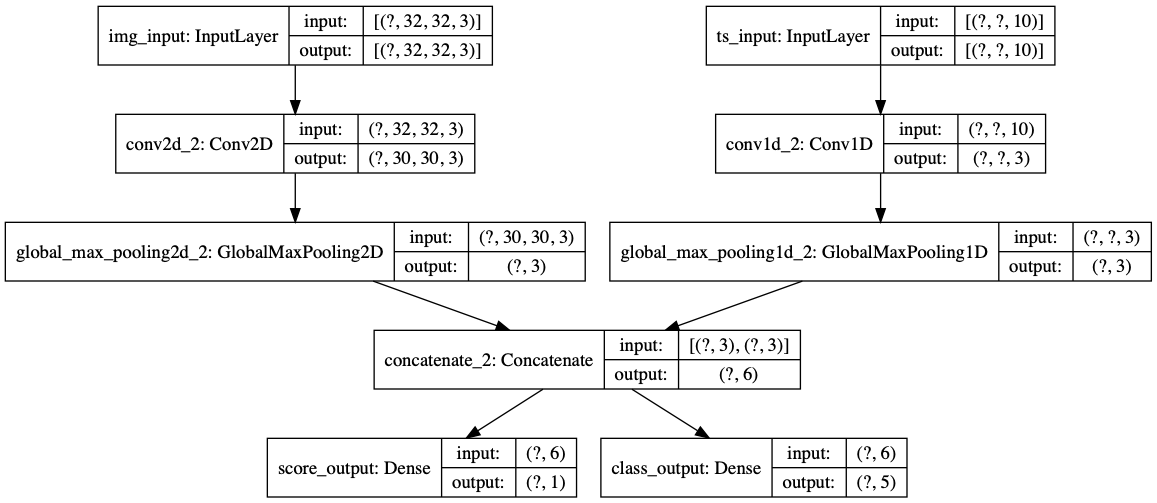

In [42]:
keras.utils.plot_model(model, 'muti_input.png', show_shapes=True)

In [43]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'score_output': keras.losses.MeanSquaredError(),
          'class_output': keras.losses.CategoricalCrossentropy()},
    metrics={'score_output': [keras.metrics.MeanAbsolutePercentageError(),
                              keras.metrics.MeanAbsoluteError()],
             'class_output': [keras.metrics.CategoricalAccuracy()]},
    loss_weights={'score_output': 2., 'class_output': 1.})

In [44]:
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets],
          batch_size=32,
          epochs=3)


Train on 100 samples
Epoch 1/3
100/100 [==============================] - 1s 8ms/sample - loss: 8.7053 - score_output_loss: 1.4183 - class_output_loss: 5.2076 - score_output_mean_absolute_percentage_error: 369.2226 - score_output_mean_absolute_error: 1.1811 - class_output_categorical_accuracy: 0.2800
Epoch 2/3
100/100 [==============================] - 0s 326us/sample - loss: 7.0403 - score_output_loss: 0.7865 - class_output_loss: 5.3240 - score_output_mean_absolute_percentage_error: 261.2932 - score_output_mean_absolute_error: 0.8912 - class_output_categorical_accuracy: 0.2800
Epoch 3/3
100/100 [==============================] - 0s 303us/sample - loss: 6.2353 - score_output_loss: 0.6484 - class_output_loss: 4.9901 - score_output_mean_absolute_percentage_error: 194.2409 - score_output_mean_absolute_error: 0.7194 - class_output_categorical_accuracy: 0.2800


In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices(({'img_input': img_data, 'ts_input': ts_data},
     {'score_output': score_targets, 'class_output': class_targets}))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
model.fit(train_dataset, epochs=3)

Epoch 1/3
2/2 [==============================] - 0s 247ms/step - loss: 5.7676 - score_output_loss: 0.4258 - class_output_loss: 4.9160 - score_output_mean_absolute_percentage_error: 146.9315 - score_output_mean_absolute_error: 0.5877 - class_output_categorical_accuracy: 0.2800
Epoch 2/3
2/2 [==============================] - 0s 19ms/step - loss: 5.5210 - score_output_loss: 0.3559 - class_output_loss: 4.7895 - score_output_mean_absolute_percentage_error: 127.1917 - score_output_mean_absolute_error: 0.5287 - class_output_categorical_accuracy: 0.2800
Epoch 3/3
2/2 [==============================] - 0s 20ms/step - loss: 5.2934 - score_output_loss: 0.2930 - class_output_loss: 4.7814 - score_output_mean_absolute_percentage_error: 109.1994 - score_output_mean_absolute_error: 0.4747 - class_output_categorical_accuracy: 0.2800


In [47]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1)
]
model.fit(x_train, y_train,
          epochs=20,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0....

In [51]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='mymodel.h5',
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0....

In [52]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
    )

In [53]:
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [54]:
tensorboard_cbk = keras.callbacks.TensorBoard(log_dir='full_log')
model.fit(dataset, epochs=10, callbacks=[tensorboard_cbk])

NameError: name 'dataset' is not defined

In [55]:
keras.callbacks.TensorBoard(
    log_dir='log',
    histogram_freq=0,
    embeddings_freq=0,
    update_freq='epoch'
)

In [60]:
def sortColor(nums):
    red, white, blue = 0, 0, len(nums)-1
    while white <= blue:
        if nums[white]==0:
            nums[red], nums[white] = nums[white], nums[red]
            white += 1
            red += 1
        elif nums[white]==1:
            white += 1
        else:
            nums[white], nums[blue] = nums[blue], nums[white]
            blue -= 1
    return nums
nums = [2,0,2,1,1,0]
print(sortColor(nums))

[0, 0, 1, 1, 2, 2]


In [61]:
def subset(nums):
    res = [[]]
    for num in sorted(nums):
        res += [item + [num] for item in res]
    return res

In [62]:
def subset(nums):
    res = [[]]
    for num in sorted(nums):
        res += [item + [num] for item in res]
    return res

In [70]:
def exist(board, word):
    if not board:
        return False
    for i in range(len(board)):
        for j in range(len(board[0])):
            if dfs(board, i, j, word):
                return True
    return False

def dfs(board, i, j, word):
    if len(word)==0:
        return True
    if i<0 or i>=len(board) or j<0 or j>=len(board[0]) or \
        word[0]!=board[i][j]:
        return False
    tmp = board[i][j]
    board[i][j] = '#'
    res = dfs(board, i+1, j, word[1:]) or \
            dfs(board, i, j+1, word[1:]) or \
            dfs(board, i-1, j, word[1:]) or \
            dfs(board, i, j-1, word[1:])
    board[i][j] = tmp
    return res

board = [
  ['A','B','C','E'],
  ['S','F','C','S'],
  ['A','D','E','E']
]
word = "ABCCED"
print(exist(board, word))

True


In [71]:
def exist(board, word):
    if not board:
        return False
    for i in range(len(board)):
        for j in range(len(board[0])):
            if dfs(board, i, j, word):
                return True
    return False

def dfs(board, i, j, word):
    if len(word)==0:
        return True
    if i<0 or i>len(board) or j<0 or j<len(board[0]) or board[i][j]!=word[0]:
        return False
    tmp = board[i][j]
    board[i][j]='#'
    res = dfs(board, i+1, j, word[1:]) or \
            dfs(board, i, j+1, word[1:]) or \
            dfs(board, i-1, j, word[1:]) or \
            dfs(board, i, j-1, word[1:])
    board[i][j] = tmp
    return res
board = [
  ['A','B','C','E'],
  ['S','F','C','S'],
  ['A','D','E','E']
]
word = "ABCCED"
print(exist(board, word))

False


In [72]:
def remove(nums):
    if len(nums)<3:
        return len(nums)
    pos = 1
    for i in range(1, len(nums)-1):
        if nums[i-1]!=nums[i+1]:
            nums[pos] = nums[i]
            pos += 1
    nums[pos] = nums[-1]
    return pos+1

In [74]:
def remove(nums):
    if len(nums)<3:
        return len(nums)
    pos = 1
    for i in range(1, len(nums)-1):
        if nums[i-1]!=nums[i+1]:
            nums[pos] = nums[i]
            pos += 1
    nums[pos] = nums[-1]
    return pos+1
nums = [1,1,1,2,2,3]
print(remove(nums))

5


In [75]:
def remove(nums):
    if len(nums)<3:
        return len(nums)
    pos = 1
    for i in range(1, len(nums)-1):
        if nums[i-1] != nums[i+1]:
            nums[pos] = nums[i]
            pos += 1
    nums[pos] = nums[-1]
    return pos+1

In [77]:
def search(nums, target):
    l, r = 0, len(nums)-1
    while l<=r:
        mid = (l+r)//2
        if nums[mid] == target:
            return True
        while l<mid and nums[l]==nums[mid]:
            l += 1
        if nums[l]<=nums[mid]:
            if nums[l]<=target<=nums[mid]:
                r = mid-1
            else:
                l = mid+1
        else:
            if nums[mid] <= target<=nums[r]:
                l = mid + 1
            else:
                r = mid -1
    return False
nums = [2,5,6,0,0,1,2]
target = 0
print(search(nums, target))

True


In [79]:
def search(nums, target):
    l, r = 0, len(nums)-1
    while l<=r:
        mid = (l+r)//2
        if nums[mid]==target:
            return True
        while l<mid and nums[l]==nums[mid]:
            l += 1
        if nums[l] <= nums[mid]:
            if nums[l] <= target <= nums[mid]:
                r = mid -1
            else:
                l = mid + 1
        else:
            if nums[mid] < target <= nums[r]:
                l = mid + 1
            else:
                r = mid - 1
    return Fasle

In [81]:
def largeArea(nums):
    nums.append(0)
    stack = [-1]
    ans = 0
    for i in range(len(nums)):
        while nums[i] < nums[stack[-1]]:
            h = nums[stack.pop()]
            w = i-stack[-1]-1
            ans = max(ans, h*w)
        stack.append(i)
    nums.pop()
    return ans
height = [2,1,5,6,2,3]  
print(largeArea(height))

10


In [82]:
def largeArea(nums):
    nums.append(0)
    stack = [-1]
    ans = 0
    for i in range(len(nums)):
        while nums[i] < nums[stack[-1]]:
            h = nums[stack.pop()]
            w = i-stack[-1]-1
            ans = max(ans, h*w)
        stack.append(i)
    nums.pop()
    return ans

In [83]:
def largeArea(nums):
    nums.append(0)
    stack = [-1]
    ans = 0
    for i in range(len(nums)):
        while nums[i]<nums[stack[-1]]:
            h = nums[stack.pop()]
            w = i - stack[-1] -1
            ans = max(ans, h*w)
        stack.append(i)
    nums.pop()
    return ans
        